In [1]:
from sklearn.datasets import fetch_openml # load MNIST data set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math # for exp in sigmoid

# 1. Load MNIST Dataset
<img src='media/MNIST_examples.png' alt='MNIST examples'>

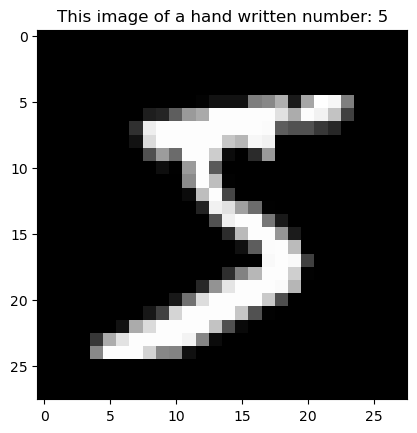

In [2]:
# load data from sklearn
mnist = fetch_openml('mnist_784')
X, y = mnist['data'], mnist['target'] # two dataframes
y_one_hot_array = pd.get_dummies(y, prefix='class').to_numpy().astype(int)
# plot first example
image = X.iloc[0].values.reshape(28, 28)
label = y.iloc[0]
plt.title(f'This image of a hand written number: {label}')
plt.imshow(image, cmap='gray')

# 2. Activation Functions

In [3]:
def ReLU(x):
    # rectified linear unit
    return np.maximum(0, x)

def SELU(x):
    # scaled exponential linear unit
    return np.where(x <= 0, 1.75809 * (np.exp(x)-1), 1.0507 * x)

def tanh(x):
    # hyperbolic tangent
    x = np.clip(x, -500, 500)  # prevent overflow
    exp_x = np.exp(x)
    exp_neg_x = np.exp(-x)
    return (exp_x - exp_neg_x) / (exp_x + exp_neg_x)


def softmax(x):
    denominator = np.sum(np.exp(x)) # sum of all the e^logit for every logit
    return np.exp(x) / denominator # normalize e^logit value by sum of e^logits


def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# 3. Initialize Numpy Neural Network
<img src='media/nn_arcitecture.png' alt='Network Arcitecture'>

## Weight Initializations

In [4]:
def xavier_init(size):
    in_dim, out_dim = size
    limit = np.sqrt(6 / (in_dim + out_dim))
    return np.random.uniform(-limit, limit, size)


def he_init(size):
    in_dim, _ = size
    stddev = np.sqrt(2 / in_dim)
    return np.random.normal(0, stddev, size)

In [5]:
X.iloc[0].values.shape

(784,)

In [36]:
x = X.iloc[0].values / 255 # normalize it
input_size = X.iloc[0].values.shape[0]
output_size = len(y.values.unique())

#### Initialize weight matrixes

# first layer of model
l1_num_nodes = 1568
l1_weights = np.random.randn(input_size, l1_num_nodes)
l1_output = np.dot(x, l1_weights) # you would just add a bias term to this
print(f'shape of layer 1 rep: {l1_output.shape}')
# second layer of the model
l2_num_nodes = 2000
l2_weights = np.random.randn(l1_num_nodes, l2_num_nodes)
l2_output = np.dot(l1_output, l2_weights) # you would just add a bias term to this
print(f'shape of layer 2 rep: {l2_output.shape}')

# Third layer
l3_num_nodes = 784
l3_weights = np.random.randn(l2_num_nodes, l3_num_nodes)
l3_output = np.dot(l2_output, l3_weights) # you would just add a bias term to this
print(f'shape of layer 3 rep: {l3_output.shape}')

# Final output layer
l4_num_nodes = output_size
l4_weights = np.random.randn(l3_num_nodes, l4_num_nodes)
l4_output = np.dot(l3_output, l4_weights) # you would just add a bias term to this
print(f'output shape: {l4_output.shape}')

shape of layer 1 rep: (1568,)
shape of layer 2 rep: (2000,)
shape of layer 3 rep: (784,)
output shape: (10,)


In [40]:
# Declare simple network
import importlib
from linearnn import linearnnclasses
importlib.reload(linearnnclasses)
from linearnn import activationfunctions

importlib.reload(activationfunctions)
from linearnn.activationfunctions import ReLU, SELU, Tanh, Softmax, DummyActivation

class CategoricalCrossEntropy:
    # soft max is incorperated with this
    def forward(self, y:np.array, y_hat:np.array):
        exp_values = np.exp(y_hat - np.max(y_hat, axis=1, keepdims=True))  # shift for numerical stability
        softmax_output = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        # Cross-entropy loss calculation
        softmax_output = np.clip(softmax_output, 1e-15, 1 - 1e-15)  # avoid log(0)
        batch_size = y.shape[0]
        loss = -np.sum(y * np.log(softmax_output)) / batch_size
        return loss
    
    def derivative(self, y:np.array, y_hat:np.array):
        exp_values = np.exp(y_hat - np.max(y_hat, axis=1, keepdims=True))
        softmax_output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return (softmax_output - y) / y.shape[0]



linearlayer = linearnnclasses.LinearLayer(
    input_size=784, 
    output_size=10, 
    activation_fn_class=DummyActivation, 
    weight_init=he_init,
    learning_rate=0.01
)


num_epochs = 200
batch_size = 100

split_position = 50_000
X_test = X.iloc[split_position:].values / 255
y_test = y_one_hot_array[split_position:,:]

train_losses = []
test_losses = []
epochs = list(range(num_epochs))

for epoch in range(num_epochs):
    # itterate over batches
    running_loss = 0.0
    batch_counter = 0 # keep track of number of epochs to get average of training losses
    for i in range(0, X.iloc[0:split_position].shape[0]-batch_size, batch_size):
        x_batch = X.iloc[i:i+batch_size].values / 255
        y_batch = y_one_hot_array[i:i+batch_size, :]


        y_hat = linearlayer.forward(x_batch, backprop=True) # do forward pass saving inputs at each step

        loss = CategoricalCrossEntropy().forward(y=y_batch, y_hat=y_hat)
        running_loss += loss

        loss_gradient = CategoricalCrossEntropy().derivative(y=y_batch, y_hat=y_hat)

        linearlayer.backward(output_gradient=loss_gradient, y = y_batch) # have to pass y for derivative of soft max

        batch_counter += 1


    running_loss /= batch_counter # get average of batch losses for the epoch
    train_losses.append(running_loss)
    


    # Evaluation on Test set (only done once per epoch)
    y_hat = linearlayer.forward(X_test, backprop=False) # back prop as false because no need store intermediate values
    
    test_loss = CategoricalCrossEntropy().forward(y=y_test, y_hat=y_hat)
    test_losses.append(test_loss)

    print(f'Epoch: {epoch}, train loss: {running_loss:0.3f}, test loss: {test_loss:0.3f}')

    
        




Epoch: 0, train loss: 2.363, test loss: 2.325
Epoch: 1, train loss: 2.296, test loss: 2.261
Epoch: 2, train loss: 2.237, test loss: 2.203
Epoch: 3, train loss: 2.183, test loss: 2.150
Epoch: 4, train loss: 2.133, test loss: 2.100
Epoch: 5, train loss: 2.085, test loss: 2.053
Epoch: 6, train loss: 2.040, test loss: 2.008
Epoch: 7, train loss: 1.998, test loss: 1.965
Epoch: 8, train loss: 1.957, test loss: 1.924
Epoch: 9, train loss: 1.918, test loss: 1.885
Epoch: 10, train loss: 1.880, test loss: 1.847
Epoch: 11, train loss: 1.844, test loss: 1.811
Epoch: 12, train loss: 1.809, test loss: 1.776
Epoch: 13, train loss: 1.776, test loss: 1.743
Epoch: 14, train loss: 1.744, test loss: 1.711
Epoch: 15, train loss: 1.713, test loss: 1.680
Epoch: 16, train loss: 1.684, test loss: 1.650
Epoch: 17, train loss: 1.655, test loss: 1.621
Epoch: 18, train loss: 1.627, test loss: 1.593
Epoch: 19, train loss: 1.601, test loss: 1.567
Epoch: 20, train loss: 1.575, test loss: 1.541
Epoch: 21, train loss: 

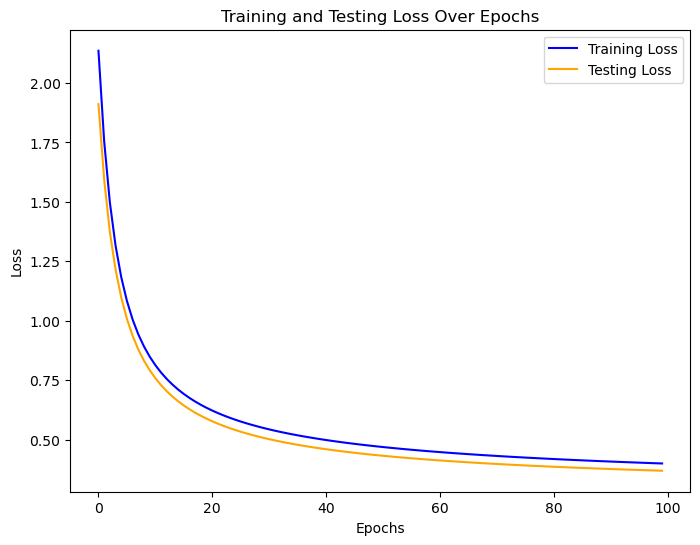

In [39]:
import matplotlib.pyplot as plt

# Assuming train_losses, test_losses, and epochs are already populated
plt.figure(figsize=(8, 6))

# Plot training loss
plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker=None)

# Plot testing loss
plt.plot(epochs, test_losses, label='Testing Loss', color='orange', marker=None)

# Add title and labels
plt.title('Training and Testing Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [144]:
x_batch = X.iloc[0:100].values / 255
print(x_batch.shape)

(100, 784)


# Using Sequential model class (under developement)

In [23]:
from linearnn import linearnnclasses
from linearnn.activationfunctions import ReLU, SELU, Tanh, Softmax
# from linearnn.optim import AdamOptimizer
from linearnn import optim
import importlib
importlib.reload(linearnnclasses)
importlib.reload(optim)

class CategoricalCrossEntropy:
    # soft max is incorperated with this
    def forward(self, y:np.array, y_hat:np.array):
        exp_values = np.exp(y_hat - np.max(y_hat, axis=1, keepdims=True))  # shift for numerical stability
        softmax_output = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        # Cross-entropy loss calculation
        softmax_output = np.clip(softmax_output, 1e-15, 1 - 1e-15)  # avoid log(0)
        batch_size = y.shape[0]
        loss = -np.sum(y * np.log(softmax_output)) / batch_size
        return loss
    
    def derivative(self, y:np.array, y_hat:np.array):
        exp_values = np.exp(y_hat - np.max(y_hat, axis=1, keepdims=True))
        softmax_output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return (softmax_output - y) / y.shape[0]



sequential_model = linearnnclasses.SequentialModel(
    input_size=784,
    output_size=10,
    hidden_layers=(1568, 784), 
    activation_fn_classes=(ReLU, SELU, ReLU, Softmax),
    weight_init=(he_init, he_init, he_init, he_init),
    loss_fn_class = CategoricalCrossEntropy,
    optimizer=None#optim.AdamOptimizer # with default settings (see linearnn/optim.py)
)
sequential_model.forward(x_batch)
sequential_model.backward(x_batch, y_one_hot_array[0:100, :])

building model...
Adding: LinearLayer input:784, output:1568, activation:<class 'linearnn.activationfunctions.SELU'>
Adding: LinearLayer input:1568, output:784, activation:<class 'linearnn.activationfunctions.ReLU'>
Adding: LinearLayer input:784, output:10, activation:<class 'linearnn.activationfunctions.Softmax'>
model built


TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

# 4. Model Training

In [263]:
num_epochs = 50
batch_size = 100

for epoch in range(num_epochs):
    # itterate over batches
    running_loss = 0.0
    for i in range(0, X.iloc[0:60000].shape[0]-batch_size, batch_size):
        x_batch = X.iloc[i:i+batch_size].values / 255
        y_batch = y_one_hot_array[i:i+batch_size, :]
        # print(np.unique(x_batch))
        loss = sequential_model.backward(x_batch, y_batch) # forward pass is incorperated in backward function
        # print(x_batch.shape)
        # print(y_batch.shape)
        print(loss)
        if loss == np.nan: print(1/0)
        # break
        running_loss += loss
    # break

    print(running_loss/(X.shape[0]/batch_size))


7.292762465215206
7.314172449721973
7.129204141841925
7.148207841704977
7.128680245987088
7.152731195564415
7.1472311280660366
7.22489715045167
7.206244743507414
7.09306089941958
7.144879556839974
7.1130051053909815
7.388344643083676
7.077581667837615
7.099552577768813
7.103527880421407
7.116570642259125
7.114268146538884
7.093622193912385
7.219028239463915
7.294398812233866
7.178690199835334
7.109915178218196
7.208174552923054
7.177926353417172
7.195112668629238
7.118757767345551
7.193112470210646
7.1331989563323885
7.163177274217185
7.118299904064668
7.24977598165777
7.1122541974183555
7.1519954911735155
7.128383522933937
7.10583277487387
7.150763298760633
7.110909920838911
7.140160857236701
7.130824779804532
7.105591796925299
7.17516111693398
7.1978415645341265
6.972018397563418
7.056152015349506
7.133973906549702
7.194210586582451
7.2382292439898155
7.151886470916285
6.993398117685756
7.1281455388152475
7.059622908124186
7.056767292819064
7.049793065249981
7.145765957842015
6.93778

KeyboardInterrupt: 

In [203]:
X[-100:-1].values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [215]:
preds = sequential_model.forward(X[-100:-1].values)

In [216]:
max_indices = np.argmax(preds, axis=1)
max_indices

array([7, 7, 7, 7, 7, 1, 9, 4, 2, 5, 7, 7, 1, 7, 7, 7, 7, 6, 1, 9, 7, 8,
       7, 7, 6, 7, 7, 2, 6, 7, 6, 9, 2, 1, 6, 9, 7, 1, 7, 7, 1, 5, 8, 8,
       9, 0, 9, 7, 9, 6, 7, 1, 8, 7, 9, 1, 9, 5, 2, 9, 5, 9, 7, 7, 7, 7,
       7, 7, 8, 7, 7, 7, 6, 5, 7, 7, 9, 7, 9, 7, 7, 9, 9, 0, 7, 9, 1, 7,
       7, 7, 7, 8, 7, 7, 7, 2, 1, 1, 1], dtype=int64)

In [217]:
np.argmax(y_one_hot_array[-100:-1, :], axis=1)

array([8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6,
       4, 1, 9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3,
       3, 9, 1, 4, 0, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3,
       6, 8, 7, 1, 5, 2, 4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 5, 0, 1, 2, 3, 4,
       5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5], dtype=int64)